In [1]:
import os
import numpy as np
from PIL import Image
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# --- Settings ---
IMAGE_SIZE = (128, 128)  # Resize all images to this size
IMG_EXTENSIONS = ['.png', '.jpg', '.jpeg']

# --- Load image dataset ---
def load_image_dataset(base_dir, as_gray=True):
    features = []
    labels = []
    print(f"Loading from {base_dir}...")
    for genre in os.listdir(base_dir):
        genre_path = os.path.join(base_dir, genre)
        if not os.path.isdir(genre_path):
            continue
        for file in os.listdir(genre_path):
            if any(file.lower().endswith(ext) for ext in IMG_EXTENSIONS):
                path = os.path.join(genre_path, file)
                try:
                    img = Image.open(path)
                    if as_gray:
                        img = img.convert("L")  # Convert to grayscale
                    img = img.resize(IMAGE_SIZE)
                    img_array = np.asarray(img).flatten()
                    features.append(img_array)
                    labels.append(genre)
                except Exception as e:
                    print(f"Failed to load {path}: {e}")
    print(f"Loaded {len(features)} samples from {base_dir}")
    return np.array(features), np.array(labels)

# --- Paths ---
train_dir = 'Dataset/spectrograms_split/train'
val_dir   = 'Dataset/spectrograms_split/val'
test_dir  = 'Dataset/spectrograms_split/test'

# --- Load datasets ---
X_train, y_train = load_image_dataset(train_dir)
X_val, y_val     = load_image_dataset(val_dir)
X_test, y_test   = load_image_dataset(test_dir)

# --- Encode labels ---
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

# --- Normalize features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# --- Define models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='rbf')
}

# --- Train and Evaluate ---
for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(X_train_scaled, y_train_enc)

    val_preds = model.predict(X_val_scaled)
    test_preds = model.predict(X_test_scaled)

    print(f"Validation Accuracy: {accuracy_score(y_val_enc, val_preds):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test_enc, test_preds):.4f}")
    print("Classification Report on Test Set:")
    print(classification_report(y_test_enc, test_preds, target_names=encoder.classes_))

    # Define a safe file name
    model_filename = f"models/{name.replace(' ', '_').lower()}.pkl"

    # Save model to .pkl
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)

    print(f"Saved model to {model_filename}")

Loading from Dataset/spectrograms_split/train...
Loaded 892 samples from Dataset/spectrograms_split/train
Loading from Dataset/spectrograms_split/val...
Loaded 269 samples from Dataset/spectrograms_split/val
Loading from Dataset/spectrograms_split/test...
Loaded 271 samples from Dataset/spectrograms_split/test

Training: Logistic Regression
Validation Accuracy: 0.8699
Test Accuracy: 0.8819
Classification Report on Test Set:
              precision    recall  f1-score   support

       blues       0.92      0.89      0.91        27
   classical       0.86      1.00      0.93        25
     country       0.95      0.78      0.86        27
       disco       0.77      0.85      0.81        27
      hiphop       0.88      0.85      0.86        26
        jazz       0.90      0.96      0.93        28
       metal       0.85      1.00      0.92        29
         pop       0.90      0.76      0.83        25
      reggae       0.93      0.86      0.89        29
        rock       0.89      0.

In [22]:
# Applying PCA Hyper parameter tuning to prevent overfitting

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define model parameter grids
models = {
    'Logistic Regression': (
        LogisticRegression(max_iter=1000),
        {
            'C': [0.001, 0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    ),
    'Random Forest': (
        RandomForestClassifier(),
        {
            'n_estimators': [100],
            'max_depth': [5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }
    ),
    'SVM': (
        SVC(),
        {
            'C': [0.01, 0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    )
}

# Train, tune, evaluate
results = {}

for model_name, (model, params) in models.items():
    print(f"\nTuning {model_name} with PCA...")
    
    grid = GridSearchCV(model, params, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
    grid.fit(X_train_pca, y_train)
    best_model = grid.best_estimator_

    for split_name, X, y in [('train', X_train_pca, y_train),
                             ('val', X_val_pca, y_val),
                             ('test', X_test_pca, y_test)]:
        y_pred = best_model.predict(X)
        acc = accuracy_score(y, y_pred)
        loss = 1 - acc
        results.setdefault(model_name, {})[f"{split_name}_acc"] = acc
        results[model_name][f"{split_name}_loss"] = loss

    print(f"Best parameters for {model_name}: {grid.best_params_}")



Tuning Logistic Regression with PCA...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters for Logistic Regression: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}

Tuning Random Forest with PCA...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters for Random Forest: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

Tuning SVM with PCA...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


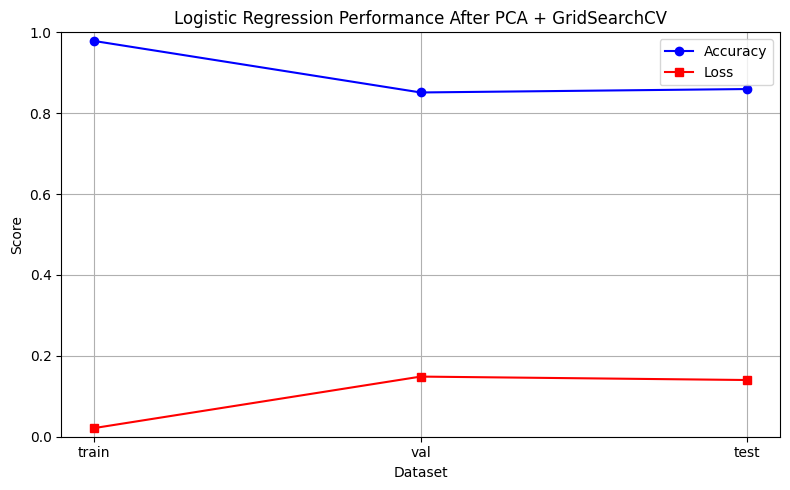

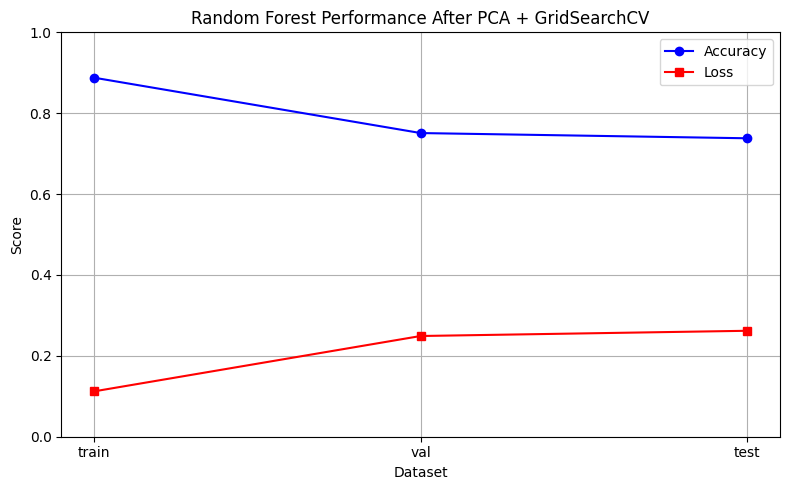

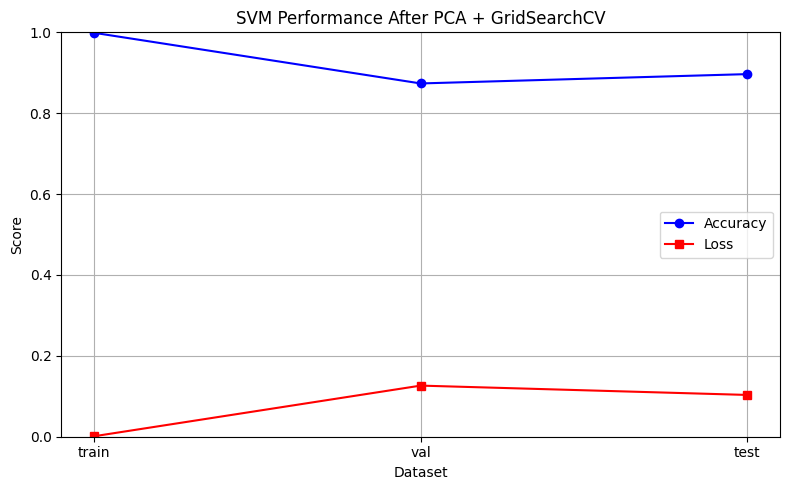

In [23]:
import matplotlib.pyplot as plt

# Plot settings
splits = ['train', 'val', 'test']

for model_name, metrics in results.items():
    acc = [metrics[f"{s}_acc"] for s in splits]
    loss = [metrics[f"{s}_loss"] for s in splits]

    plt.figure(figsize=(8, 5))
    
    plt.plot(splits, acc, marker='o', label='Accuracy', color='blue')
    plt.plot(splits, loss, marker='s', label='Loss', color='red')
    
    plt.title(f'{model_name} Performance After PCA + GridSearchCV')
    plt.xlabel('Dataset')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



[TEST SET] Accuracy: 0.9004
Classification Report:
              precision    recall  f1-score   support

       blues       0.93      0.93      0.93        27
   classical       0.96      0.96      0.96        25
     country       0.95      0.78      0.86        27
       disco       0.75      0.89      0.81        27
      hiphop       0.83      0.96      0.89        26
        jazz       0.93      1.00      0.97        28
       metal       1.00      0.97      0.98        29
         pop       0.90      0.76      0.83        25
      reggae       0.93      0.86      0.89        29
        rock       0.86      0.89      0.88        28

    accuracy                           0.90       271
   macro avg       0.90      0.90      0.90       271
weighted avg       0.91      0.90      0.90       271



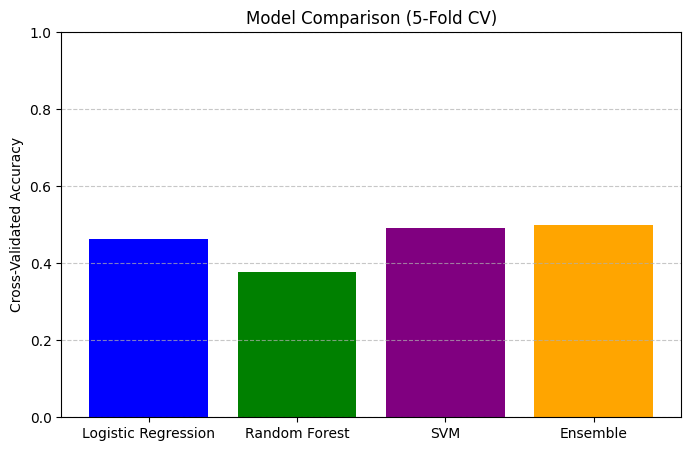

In [25]:
# --- Cross-Validated Weighted Ensemble Voting Classifier ---
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Reinitialize models with best parameters
lr = LogisticRegression(max_iter=1000, **{'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'})
rf = RandomForestClassifier(**{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100})
svm = SVC(probability=True, **{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'})

# Evaluate individual models with cross-validation
cv = 5
lr_scores = cross_val_score(lr, X_train_pca, y_train, cv=cv, scoring='accuracy')
rf_scores = cross_val_score(rf, X_train_pca, y_train, cv=cv, scoring='accuracy')
svm_scores = cross_val_score(svm, X_train_pca, y_train, cv=cv, scoring='accuracy')

# Fit models on full training data after CV
lr.fit(X_train_pca, y_train)
rf.fit(X_train_pca, y_train)
svm.fit(X_train_pca, y_train)

# Average scores to determine weights
weights = [np.mean(lr_scores), np.mean(rf_scores), np.mean(svm_scores)]

# Create voting classifier with weights
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('svm', svm)],
    voting='soft',
    weights=weights
)

# Cross-validate ensemble
ensemble_scores = cross_val_score(voting_clf, X_train_pca, y_train, cv=cv, scoring='accuracy')

# Train ensemble on full data
voting_clf.fit(X_train_pca, y_train)

# Predict on test data
test_preds = voting_clf.predict(X_test_pca)

# Print test performance
print("\n[TEST SET] Accuracy: {:.4f}".format(accuracy_score(y_test, test_preds)))
print("Classification Report:")
print(classification_report(y_test, test_preds, target_names=encoder.classes_))

# Plot accuracy comparison (cross-validated mean scores)
model_scores = {
    'Logistic Regression': np.mean(lr_scores),
    'Random Forest': np.mean(rf_scores),
    'SVM': np.mean(svm_scores),
    'Ensemble': np.mean(ensemble_scores)
}

plt.figure(figsize=(8, 5))
plt.bar(model_scores.keys(), model_scores.values(), color=['blue', 'green', 'purple', 'orange'])
plt.ylabel("Cross-Validated Accuracy")
plt.title("Model Comparison ({}-Fold CV)".format(cv))
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


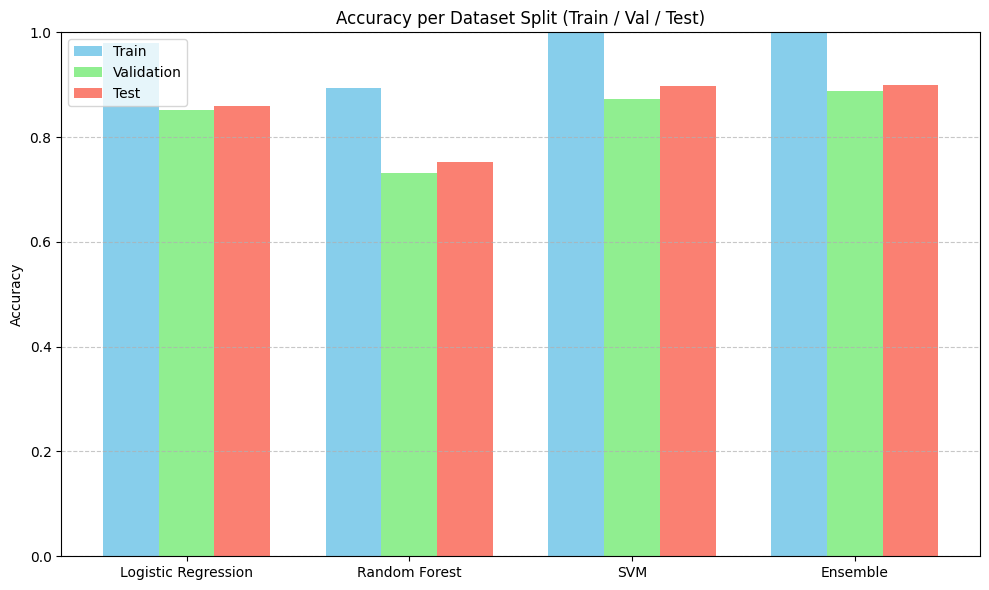

In [26]:
# --- Plot Train, Validation, and Test Accuracy for All Models ---
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Compute accuracy on all splits
accuracies = {
    'Logistic Regression': {
        'train': accuracy_score(y_train, lr.predict(X_train_pca)),
        'val': accuracy_score(y_val, lr.predict(X_val_pca)),
        'test': accuracy_score(y_test, lr.predict(X_test_pca))
    },
    'Random Forest': {
        'train': accuracy_score(y_train, rf.predict(X_train_pca)),
        'val': accuracy_score(y_val, rf.predict(X_val_pca)),
        'test': accuracy_score(y_test, rf.predict(X_test_pca))
    },
    'SVM': {
        'train': accuracy_score(y_train, svm.predict(X_train_pca)),
        'val': accuracy_score(y_val, svm.predict(X_val_pca)),
        'test': accuracy_score(y_test, svm.predict(X_test_pca))
    },
    'Ensemble': {
        'train': accuracy_score(y_train, voting_clf.predict(X_train_pca)),
        'val': accuracy_score(y_val, voting_clf.predict(X_val_pca)),
        'test': accuracy_score(y_test, voting_clf.predict(X_test_pca))
    }
}

# Plotting
labels = list(accuracies.keys())
x = range(len(labels))
train_scores = [accuracies[m]['train'] for m in labels]
val_scores = [accuracies[m]['val'] for m in labels]
test_scores = [accuracies[m]['test'] for m in labels]

bar_width = 0.25
plt.figure(figsize=(10, 6))
plt.bar([i - bar_width for i in x], train_scores, width=bar_width, label='Train', color='skyblue')
plt.bar(x, val_scores, width=bar_width, label='Validation', color='lightgreen')
plt.bar([i + bar_width for i in x], test_scores, width=bar_width, label='Test', color='salmon')

plt.xticks(x, labels)
plt.ylabel("Accuracy")
plt.title("Accuracy per Dataset Split (Train / Val / Test)")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
